In [1]:
# Import libraries
import re
import nltk
import pickle
import requests

import numpy as np
import pandas as pd
import datetime as dt 
import matplotlib.pyplot as plt

from bokeh.models import *
from bokeh.plotting import *
from datetime import datetime
from bs4 import BeautifulSoup
from collections import Counter
from gensim.models import Word2Vec
from bokeh.layouts import column, row
from bokeh.palettes import Category20, Viridis256
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet, brown, words

In [2]:
nltk.download('words')

[nltk_data] Downloading package words to /Users/Jean-
[nltk_data]     BaptistePROST/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:
data='Data/russian-troll-tweets/IRAhandle_tweets_'
pickle_files='Pickles/'
WORD_FREQ = 'Data/wordfrea.xlsx'
plot_files='Plots/'
csv_files='CSV/'

# Introduction

The goal of this notebook is to represent the tweet by topics (tahter than category). <br>

By looking at the most popular hastag per day, we decided to define arbitrary categories that seemed relevant to characterized the tweets. A first list of words was build for each topic (~ 7 words/topic), then the `Word2Vec` model was used to exten the list. The model enables to find the words that have a large (cosine) similarity the the its word space. The topic became ~10 times larger. <br>

The tweet activity (number of tweets per day) for each topic was ploted. Clear peaks of activity were observable. 
Are those peaks related to a specific event?


To figure this out, we used [Wiki Portal](https://en.wikipedia.org/wiki/Portal:Current_events) to retrived the information about the event of a particular day. An automatic event dector was build. For every spike of each topic, we tryed to match an event description scrapped from Wiki Portal.<br>
We were thus able to label some peak of the tweet activity for each category.

# Data Loading & Word2Vec model

In [4]:
#loading data build in Word2vec.ipynb
def load_df(filename=(pickle_files+'df_final.pkl')):
    with open(filename, 'rb') as d:
        df=pickle.load(d)
    print(' DafaFrame loaded <--')
    return df

In [5]:
df=load_df()
df.head()

 DafaFrame loaded <--


,publish_date,content,account_category,Clean_tweet,hashtags
0,2017-10-01,"""We have a sitting Democrat US Senator on tria...",RightTroll,"[sit, democrat, us, senat, trial, corrupt, bar...",[]
1,2017-10-01,Marshawn Lynch arrives to game in anti-Trump s...,RightTroll,"[marshawn, lynch, arriv, game, anti-trump, shi...",[]
2,2017-10-01,Daughter of fallen Navy Sailor delivers powerf...,RightTroll,"[daughter, fallen, navi, sailor, deliv, power,...",[#BoycottNFL]
3,2017-10-01,JUST IN: President Trump dedicates Presidents ...,RightTroll,"[presid, trump, dedic, presid, cup, golf, tour...",[]
4,2017-10-01,"19,000 RESPECTING our National Anthem! #StandF...",RightTroll,"[respect, nation, anthem, stand, anthem]",[#StandForOurAnthem]


*Word Freq* is a online dictionary (wordfrequency.info) that gives the occurency the 5000 most commun english words.

In [6]:
#load data frequency from http://www.wordfrequency.info
wordfrequency = pd.read_excel(WORD_FREQ, header=0, index_col=[0], usecols=3).dropna()
wordfrequency.Frequency = wordfrequency.Frequency/(wordfrequency.Frequency.sum())
wordfrequency.rename(columns={'\xa0\xa0\xa0Word' : 'Word', 'Part of speech' : 'PoS'}, inplace=True)
wordfrequency.Word = wordfrequency.apply(lambda row: row['Word'].replace("\xa0\xa0\xa0", ''), axis=1)

#5 most communs words
wordfrequency.head(5)

,Word,PoS,Frequency
Rank,,,
1.0,the,a,0.066825
2.0,be,v,0.038041
3.0,and,c,0.032569
4.0,of,i,0.031365
5.0,a,a,0.030759


**Word2Vec model**

In [7]:
embedding=100
#non empty clean tweet
tweets=df[df.Clean_tweet.isnull()==False]['Clean_tweet'] #take non empty clean tweet

model = Word2Vec(tweets.tolist(), min_count=1, size=embedding, seed=12)
model.train(tweets.tolist(), epochs=3, total_examples=model.corpus_count)
vocab_model=model.wv.vocab
print(model)

Word2Vec(vocab=29316, size=100, alpha=0.025)


# Topics

## List

We have identify a list of topic that are frequent and were a debat at the time. The list will get expanded thanks to the Word2Vec model. The words that hace a (cosine) similarity larger than a threshold (0.6) are kept and appended to the list of topics.

### Build extended list

In [8]:
stemmer = PorterStemmer()

def get_related_words(topics, model, min_similarity=0.6):
    """Get the words that are similar in the word2vec space. 
    min_similarity determines the threshold of similarity
    RETURNS: an extendent list for each topics"""
    topic_extended=[] #new list of words
    
    for topic in topics:
        new_words=[]
       
        for idx, word_raw in enumerate(topic):
            #modifies the wors as in the preprocessing
            word=stemmer.stem(word_raw.lower())
            
            if idx == 0:
                new_words.append(word_raw)
                new_words.append(word)
            
            try: #if the word is in the vocab
                related=model.wv.most_similar(word, topn=30) 
                new_words+=[related[idx][0] for idx, _ in enumerate(related) if related[idx][1] >= min_similarity] + [word]
            
            except KeyError: #the word is not in the vocabulary (anymore)
                continue
                
        topic_extended.append(new_words)
    
    return topic_extended


#We will create a new col of stemmed words of wiki's events to compare with tweets keywords
link_numbers=('http', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '-') #
stemmer = PorterStemmer()
stop_w=[word.replace('\'','') for word in stopwords.words('english')]+ ['', '&amp', 'amp','rt'] 

def tokenize(text):
    """Split the the text into a list of cleaned words"""
    text_cleaned = ''.join(ch for ch in text if ch not in '#!"$%&\()*+,./:;<=>?@[\\]^_{|}~\'').split(' ') 
    
    words= [word.lower().encode('ascii',errors='ignore').decode() for word in text_cleaned \
            if not ( (word.startswith(link_numbers)) | (word.endswith(link_numbers)) )]
    
    words=[stemmer.stem(word) for word in words if word not in stop_w ]
        
    if len(words) > 0:
        return words
    else: #tweets that contains only links or emojiis ...
        pass


In [46]:
#the firs word of the list represents the concept of each list.
topics_raw=[['Music', 'lyrics', 'album','musician', 'nowplaying', 'soundcloud','rap', 'rnb','hip-hop', 'eminem','nas', 'horsemen', 'dj', 'wayne', 'snoop', 'youtube', 'drake', 'listen'],\
        ['Movies', 'tv', 'actor', 'netflix', 'trailer', 'must-see', 'episod', 'serie', 'marvel'],\
        ['Sport', 'NBA', 'basketball', 'playoff', 'hockey', 'mvp', 'football', 'soccer', 'tournament', 'championship'],\
        ['Trump', 'melania', 'Donald', 'trump2016','realdonaldtrump', 'anti-trump', 'maga', 'MakeAmericaGreatAgain', 'presidenttrump'],\
        ['Hillary', 'hilliari',  'HeforShe', 'IamWithHer', 'crookedHillary', 'clinton','killari','neverhillari', ],\
        ['Hacking', 'emails', 'DNC'],\
        ['Sanders', 'bernie', 'bern'],\
        ['Obama', 'barack', 'michelle'],\
        ['Election', 'campaign', 'GOP','gopdebate', 'DNC', 'Dem', 'demdebate', 'vote', 'Ivoted', 'debate', 'primary', 'convention'],\
        ['Voter', 'fraud', 'registration'],\
        ['Healthcare', 'obamacare', 'medicaid', 'aca'],\
        ['Gouvernment', 'senator', 'mcconnel', 'congress', 'lawmaker', 'gov', 'bureaucrat', 'govern'],\
        ['Religion', 'islam', 'christianism', 'judaism', 'bible'],\
        ['Conservative', 'tcot', 'ccot', 'pjnet', 'patriot', 'illegal', 'immigrant', 'veteran', 'vet', 'anthem'],\
        ['Liberal', 'leftist' ],\
        ['Gun', 'self-defense', 'carry', 'backgroundcheck', '2a'],\
        ['Terrorism', 'terror' 'terrorist', 'parisattack', 'londonattack', 'shootings', 'baltimore', 'bombings', 'explosion', 'Chattanooga', 'prayforbrussel', 'brussel', 'massacre', 'Bernardino', 'SanBernardino', 'attack'],\
        ['Fear', 'Korea', 'North', 'NorthKorea', 'balistic', 'Russia', 'putin', 'Geopolotics', 'kim', 'jong', 'kimjongun'],\
        ['BlackLivesMatter','BlackLiveMatters', 'black', 'trayvonmartin', 'trayvon','martin', 'mikebrown', 'sandrabland', 'bland', 'kaepernick','policeviolence', 'brutality' , 'fuckthepolice', 'cop', \
         'racial', 'blacktwitter', 'colin', 'kaepernick','racism' , 'blm', 'hill', 'MillionManMarch', 'amerikkka', 'whitesupremacy', 'harris', 'tyrone',\
         'racisme', 'blacktwitter', 'TamirRice', 'slavery', 'garner', 'pro-black', 'wearealltrayvon', 'whiteprivilege', 'doublestandard', 'oscarsowhite', 'stereotype', 'staywoke'],\
        ['MeToo', 'Weinstein', 'sexual', 'harassment', 'predator', 'feminist', 'feminism'],\
        ['FakeNews', 'fakenewsmedia', 'hoax', 'debunk', 'msm', 'bogus', 'deepstate'],\
        ['News', 'report', 'breaking', 'nyt', 'wsj', 'abc', 'msnbc'],\
        ['Scandal', 'money', 'WellsFargo', 'Fargo', 'ImranAwan', 'Imran', 'Awan', 'Wasserman'],\
        ['Charlottesville','alt-righ', 'alt-left',  'neonazi', 'neo-nazi','kkk', 'klan', 'supremacist', 'unitetheright'], \
        ['Economy', 'deal', 'Nafta','stock', 'market','bitcoin', 'nasdaq', 'aaa', 'G20']]

print('We have chosen {} topics ({} words):\n    {}'.format(len(topics_raw), len(sum(topics_raw,[])), '\n    '.join([topic[0] for topic in topics_raw])))

topics_treated=[]
for topic in topics_raw:
    topics_treated.append([word.lower() for word in topic])

We have chosen 25 topics (223 words):
    Music
    Movies
    Sport
    Trump
    Hillary
    Hacking
    Sanders
    Obama
    Election
    Voter
    Healthcare
    Gouvernment
    Religion
    Conservative
    Liberal
    Gun
    Terrorism
    Fear
    BlackLivesMatter
    MeToo
    FakeNews
    News
    Scandal
    Charlottesville
    Economy


**Extending the list:**

In [47]:
topic_extended=get_related_words(topics_raw, model, min_similarity=0.6)

print('The extended list is {} long. It can be read at the end of the Notebook.'.format(len(sum(topic_extended,[]))))

The extended list is 1439 long. It can be read at the end of the Notebook.


**Vectorizing tweets** <br>
Each tweet with respect to the topic. If a tweet contains a word contained in the list of a certain topic, then it will have a non null composant in this topic column.

In [48]:
def tweet_topics(df, topic_extended):
    """Add a column corresponding to each topic. Fills 1 if the tweet has a word 
    related to the topic, 0 otherwise """ 
    
    df_tmp=df[df['Clean_tweet'].isnull()==False]['Clean_tweet']
    for topic in topic_extended:
        df[topic[0]]= df_tmp.apply(lambda words: 1 if len(set(words) & set(topic))> 0 else 0)
        df[topic[0]].fillna(0, inplace=True)

tweet_topics(df, topic_extended)

In [49]:
df.head(5)

,publish_date,content,account_category,Clean_tweet,hashtags,Music,Movies,Sport,Trump,Hillary,...,Fear,BlackLivesMatter,MeToo,FakeNews,News,Scandal,Charlottesville,Economy,Categorical,hash_cat
0,2017-10-01,"""We have a sitting Democrat US Senator on tria...",RightTroll,"[sit, democrat, us, senat, trial, corrupt, bar...",[],0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0
1,2017-10-01,Marshawn Lynch arrives to game in anti-Trump s...,RightTroll,"[marshawn, lynch, arriv, game, anti-trump, shi...",[],0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,2017-10-01,Daughter of fallen Navy Sailor delivers powerf...,RightTroll,"[daughter, fallen, navi, sailor, deliv, power,...",[#BoycottNFL],0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,2017-10-01,JUST IN: President Trump dedicates Presidents ...,RightTroll,"[presid, trump, dedic, presid, cup, golf, tour...",[],0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
4,2017-10-01,"19,000 RESPECTING our National Anthem! #StandF...",RightTroll,"[respect, nation, anthem, stand, anthem]",[#StandForOurAnthem],0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


## Plotting - tweet activity

In [50]:
topic_plot = figure(plot_width=950, plot_height=600, x_axis_type='datetime', toolbar_location="above")
#colorplot=Category20[len(topic_extended)] #form the bokeh palettes
colorplot = ['darkolivegreen', 'darkmagenta','aqua', 'aquamarine', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki', 'darkolivegreen']
start_date = df.publish_date.min()
end_date = df.publish_date.max()


for color, topic in enumerate(topic_extended): #iterates over each topic
    topic_tmp=topic[0]
    df_plot=pd.DataFrame(data=df[df[topic_tmp]==1].publish_date.value_counts().sort_index())
    
    source = ColumnDataSource(data=df_plot)
    topic_plt_tmp=topic_plot.line(x='index', y='publish_date', source=source,\
            line_width=2, alpha=0.8, legend=topic_tmp, color=colorplot[color])
    
    topic_plt_tmp.visible=False

topic_plt_tmp.visible=True

topic_plot.legend.location = 'top_left'
topic_plot.legend.click_policy='hide'
topic_plot.title.text = 'Tweeting activity according topic'

hover_tool=tools.HoverTool(
    tooltips=[
        ('Date', '@index{%b %d, %Y}'),
        ('Number of tweets','@publish_date')],

    formatters={
        'index' : 'datetime', # use 'datetime' formatter for 'date' field
        'publish_date' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline',
    attachment='above',
    show_arrow=True,
)

topic_plot.tools.append(hover_tool)

output_file(plot_files+'Topic_noEvent.html')
save(topic_plot)

'/Users/Jean-BaptistePROST/Documents/EPFL/ADA-Proj-18/Plots/Topic_noEvent.html'

**The plot can be seen [here](Plots/Topic_noEvent.html)**

# Web scrapping

We use Wikipedia Portal which lists every event that have happened for each day. The html template is always the same enabling us to efficiently scrap it.



We want to detect the event related to the spike of tweets:
* For each categry, a threshold is define to localize the date spikes. 
* Wikipedia Portal is scrapped at the url of the date. The text follows the same pre-process as the tweets words.
* A matching of the subsection of the web page and the word of the list is done.
* We retrieve the description of the event if it its related to the topic.

In [51]:
#Getting web page
WIKI_PORTAL = "https://en.wikipedia.org/wiki/Portal:Current_events/"

def event_scrapper(date):
    """Retrieve the information of the events that happened around a date window"""
    
    #take a day before and one day after the date
    dates = [date + dt.timedelta(day,0) for day in [-1,0]]
    #daily events are stored in df
    event_df = pd.DataFrame(columns=['Date', 'Description', 'Category', 'Link'])
    
    for date in dates:
        #strftime gives 0-padded days...
        year = date.strftime("%Y")
        month = date.strftime("%B")
        day = re.sub("^[0]", "", date.strftime("%d"))  #removing 0 at beggining of day

        #right format for wiki portal and requesting html
        url_date = year + "_" + month + "_" + day
        r = requests.get(WIKI_PORTAL + url_date)
        
        #print('Response status code: {0}\n'.format(r.status_code))
        
        page_body = r.text
        soup = BeautifulSoup(page_body, 'html.parser')
        regex=re.compile(r"(\(([^)]+)\))[,. ]*", re.IGNORECASE)

        #For every category of events (dt), we look for every events from bullet list (li)
        if soup.findAll("dt"):
            
            for category in soup.findAll("dt"):

                li = category.findNext("li")
                while li:
                    #replacing \n, and removing sources: text. e.g. (CNN). 
                    #we decided to split text using regex and keeping only text before first source
                    no_source = re.sub(regex,'',li.getText().replace('\n', '. ') )
                    new_event = pd.DataFrame({'Date': [date], \
                                              'Description': [no_source],\
                                              'Category': [category.getText()], \
                                              'Link': [li.a]})


                    event_df = event_df.append(new_event, ignore_index=True, sort=False)
                    li = li.findNextSibling("li")
            
            #event_df['Stemmed_Content']=event_df.apply(lambda row: tokenize(row['Description']), axis=1)
            
        
        else: #other template of wiki portal 
            for category in soup.findAll("p"):
                category_title=category.findNext().getText()
                li = category.findNext("li")
                while li:
                    no_source = re.sub(regex,'',li.getText().replace('\n', '. ') )
                    new_event = pd.DataFrame({'Date': [date], \
                                              'Description': [no_source],\
                                              'Category': [category_title], \
                                              'Link': [li.a]})


                    event_df = event_df.append(new_event, ignore_index=True, sort=False)
                    li = li.findNextSibling("li")

        
    #stemming the content of the events description
    event_df['Stemmed_Content']=event_df.apply(lambda row: tokenize(row['Description']), axis=1)
    event_df.reset_index(inplace=True)

    return event_df


def event_detector(df, topic_extended):
    """Detect the event by web scrapping. Returns the dataframe of events' description
    per day, the topic and the recall of the process (number of event that match over
    the number of tweet spikes)"""
    print('Srapping ...')
    
    events_df=pd.DataFrame(columns=['Date', 'Topic', 'Event', 'Stemmed'])
    nb_dates=0
    nb_detected=0
    
    for topic in topic_extended:
        topic_tmp=topic[0]
        print('  _ '+topic_tmp)
        
        #create dataframe
        df_topic=pd.DataFrame(data=df[df[topic_tmp]==1].publish_date.value_counts().sort_index().reset_index())
        df_topic.rename(columns={'index':'Date', 'publish_date': 'Count'}, inplace=True)

        #get date  where tweet activity is above the thresold
        threshold=df_topic.Count.mean() + 2.25*df_topic.Count.std()
        dates_thr=df_topic[df_topic.Count >= threshold].index
        #less than threshold?
        dates=[df_topic.loc[date,'Date'] for date in dates_thr if df_topic.loc[date-1,'Count'] < threshold]
        
        for date in dates:
            nb_dates+=1 #counter for recall score
            event=event_scrapper(date)
            
            
            try: 
                #matching the description and the words of the topic
                matching_score=event.Stemmed_Content.apply(lambda words: len(set(words) & set(topic)))
                max_match=matching_score.max() 
                #print(max_match)
                
                #adapt the threhosld relative the length of the topic list
                if (len(topic)>150)  | (topic_tmp=='Trump') | (topic_tmp=='Hillary'): 
                    if (max_match > 1) : #avoid empty results
                        nb_detected+=1 #counter for recall score

                        #if two descriptions have the same matching score
                       # print(matching_score)#[matching_score==max_match]
                        #print('max index=',matching_score[matching_score==max_match].index.tolist())
                        for idx_max_match in matching_score[matching_score==max_match].index:

                            tmp=pd.DataFrame({'Date': [event.loc[idx_max_match, 'Date']], \
                                              'Topic': [topic_tmp], \
                                              'Event': [event.loc[idx_max_match,'Description']]})
                            events_df=events_df.append(tmp, ignore_index=True, sort=False)
                    
                elif (max_match >0):
                    nb_detected+=1 #counter for recall score

                    #if two descriptions have the same matching score
                   # print(matching_score)#[matching_score==max_match]
                    #print('max index=',matching_score[matching_score==max_match].index.tolist())
                    for idx_max_match in matching_score[matching_score==max_match].index:

                        tmp=pd.DataFrame({'Date': [event.loc[idx_max_match, 'Date']], \
                                          'Topic': [topic_tmp], \
                                          'Event': [event.loc[idx_max_match,'Description']]})
                        events_df=events_df.append(tmp, ignore_index=True, sort=False)
            
            except AttributeError: #track of potential error
                print(date)
                continue
            
            except TypeError:
                print('No content has been found during scrap')
    
    
    events_df.drop_duplicates(inplace=True)
    
    return events_df, nb_detected/nb_dates, 
    
    

In [52]:
events_df, recall= event_detector(df, topic_extended)

Srapping ...
  _ Music
  _ Movies
  _ Sport
  _ Trump
  _ Hillary
  _ Hacking
  _ Sanders
  _ Obama
  _ Election
  _ Voter
  _ Healthcare
  _ Gouvernment
  _ Religion
  _ Conservative
  _ Liberal
  _ Gun
  _ Terrorism
  _ Fear
  _ BlackLivesMatter
  _ MeToo
  _ FakeNews
  _ News
  _ Scandal
  _ Charlottesville
  _ Economy


In [53]:
print('The event detector matched {:0.2f}% ({}) of the tweet peak'.format(100*recall, events_df.shape[0]))

The event detector matched 44.69% (141) of the tweet peak


### Plotting

In [54]:
plot_threshold=False #explicitly plot the threshold detection

start_date = df.publish_date.min()
end_date = df.publish_date.max()

topic_plot = figure(plot_width=950, plot_height=600, x_axis_type='datetime',\
                    y_range=[-10,4800], toolbar_location=None)

#colorplot=Category20[len(topic_extended)] #form the bokeh palettes
colorplot = ['darkolivegreen', 'black', 'darkmagenta','tomato', 'dodgerblue' , 'chartreuse', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'darkgoldenrod', 'chocolate', 'coral', 'cornflowerblue', 'crimson', 'gold', 'darkblue', 'darkcyan', 'hotpink', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki', 'darkolivegreen']


ymax=[]
legend_tmp=[]


for color, topic in enumerate(topic_extended): #iterates over each topic
    topic_tmp=topic[0]

    # ---- Tweets ---- #
    to_plot = df[df[topic_tmp]==1].publish_date.value_counts().sort_index()
    df_plot=pd.DataFrame(data=to_plot)
    ymax.append(df_plot.publish_date.max())
    
    source = ColumnDataSource(data=df_plot)
    topic_plt_tmp=topic_plot.line(x='index', y='publish_date', source=source,\
            line_width=2, alpha=0.9, color=colorplot[color])

    
    hover_tool=tools.HoverTool(
        tooltips=[
            ('Date', '@index{%b %d, %Y}'),
            ('Number of tweets','@publish_date')],
        formatters={
            'index' : 'datetime', 
            'publish_date' : 'printf',},   
        mode='vline',
        attachment='above',
        renderers=[topic_plt_tmp])

    topic_plot.tools.append(hover_tool)
    topic_plt_tmp.visible=False

    # ---- Events ---- #
    event_plot=events_df[events_df['Topic']==topic_tmp].copy()
    event_plot['Y']=4650
    source_event=ColumnDataSource(data=event_plot)
    event_plot_tmp=topic_plot.scatter(x='Date', y='Y', source=source_event,\
                                       fill_color=colorplot[color], color=None, size=10, alpha=0.5)
    
    hover_event=tools.HoverTool(
        tooltips="""<div style="max-width: 700px; font-family: "HelveticaNeue-Light","Helvetica Neue Light","Helvetica Neue",Helvetica,Arial,"Lucida Grande",sans-serif">
<div><span style="color: #26aae1;">Event</span>: @Event</div>
<div><span style="color: #26aae1;">Date</span>: @Date{%b %d, %Y}</div>
</div>""",
        formatters={'Event' : 'printf', 'Date' : 'datetime',  },  
        mode="vline",
        attachment='below',
        show_arrow=False,
        renderers=[event_plot_tmp])

    topic_plot.tools.append(hover_event)
    event_plot_tmp.visible=False
    
        
    if plot_threshold:
        threshold=df_plot.publish_date.mean() + 2* df_plot.publish_date.std()
        threshold_plt_tmp=topic_plot.line(x=[start_date,end_date],\
                                      y=[threshold,threshold],\
                                      color=colorplot[color], alpha=0.5, )
        threshold_plt_tmp.visible=False
    
        legend_tmp.append((topic_tmp,[threshold_plt_tmp, topic_plt_tmp,  event_plot_tmp]))
    
        #displays only the first line at the begining
        if color==0:
            threshold_plt_tmp.visible=True
            event_plot_tmp.visible=True
            topic_plt_tmp.visible=True
            
    else:
        
        legend_tmp.append((topic_tmp,[topic_plt_tmp,  event_plot_tmp]))
    
        #displays only the first line at the begining
        if color==0:
            event_plot_tmp.visible=True
            topic_plt_tmp.visible=True
            


legend = Legend(items=legend_tmp,\
               click_policy='hide')
topic_plot.legend.location = 'left'
topic_plot.legend.orientation = "vertical"
topic_plot.legend.click_policy='hide'
topic_plot.legend.label_text_font_size='8pt'

topic_plot.title.text = 'Tweeting Activity According to the Topics'
topic_plot.yaxis.bounds=(0,max(ymax))
topic_plot.yaxis.axis_label='Number of tweets'

topic_plot.add_layout(legend, 'left')
topic_plot.legend.spacing = 2
topic_plot.legend.margin = 0

In [55]:
output_file(plot_files+'Topic_Events.html')
save(topic_plot)

'/Users/Jean-BaptistePROST/Documents/EPFL/ADA-Proj-18/Plots/Topic_Events.html'

The plot can be seen [here](Plots/Topic_Events.html)

# Tweets' distribution statisitcs

In [56]:
df['Categorical'] =0
df['Categorical'] =np.sum(df[df.columns[5:]], axis=1)

In [57]:
def save_topic_df(df, filename=pickle_files +'topic_df.plk'):
   
    with open(filename, 'wb') as df_top:
        pickle.dump(df, df_top, pickle.HIGHEST_PROTOCOL)
    print('Dateframe saved -->')
        
save_topic_df(df)

Dateframe saved -->


In [58]:
def get_category_distribution(df, topic_list):
    '''
    Returns the percentage of tweets by topic
    '''
    results = pd.DataFrame()
    tot = len(df)
    tot_r = len(df[df.account_category == 'RightTroll'])
    tot_l = len(df[df.account_category == 'LeftTroll'])
    
    for topic in topic_list:
        topic_tmp=topic[0]
        results.loc[topic_tmp, 'Percent'] = np.round(100*(df[topic_tmp].sum()/tot),2)
        results.loc[topic_tmp, 'Percent_Right'] = np.round(100*(df[df.account_category == 'RightTroll'][topic_tmp].sum()/tot_r),2)
        results.loc[topic_tmp, 'Percent_Left'] = np.round(100*(df[df.account_category == 'LeftTroll'][topic_tmp].sum()/tot_l),2)
    
    return results

def uncategorized_vocab(tweets, min_occurence=30):
    """Gathers all the words that are more frequent than min_occurence"""
    voc_raw=[]
    for words in tweets:
        if words: #if not None
            voc_raw+=words # add to voca
    count_=Counter(voc_raw) #count frequency
    uncat_voc = pd.DataFrame.from_dict(count_, orient='index').reset_index()
    uncat_voc = uncat_voc.rename(columns={'index':'word', 0:'count'})
    uncat_relevant=pd.DataFrame()
    
    for i in range(len(uncat_voc)):
        if (uncat_voc.iloc[i]['word'] not in stop_w) & (len(uncat_voc.iloc[i]['word']) > 4):
            uncat_relevant.loc[i, 'Word'] = uncat_voc.iloc[i]['word']
            uncat_relevant.loc[i, 'Count'] = uncat_voc.iloc[i]['count']

    
    return uncat_relevant

def get_uncat_voc(tweets, min_count=30):
    """Recovers the vocabulary from pickles"""
    filename=pickle_files+'uncat_vocabulary_'+str(min_count)+'.pkl'
    
    try:
        with open(filename, 'rb') as uncat_voc:
            uncat_vocabulary=pickle.load(uncat_voc) 
        print("Vocab loaded <---")
            
    except: 
        uncat_vocabulary= uncategorized_vocab(tweets)
        
        with open(filename, 'wb') as uncat_voc:
            pickle.dump(uncat_vocabulary, uncat_voc, pickle.HIGHEST_PROTOCOL) #saving the voc
            
    return uncat_vocabulary

In [59]:
topic_proportion = get_category_distribution(df, topic_extended)

In [60]:
cat_tweet = (100*len(df[df.Categorical > 0])/len(df))
r_cat_tweet = (100*len(df[(df.Categorical > 0) & (df.account_category == 'RightTroll')]) / len(df[df.account_category == 'RightTroll']))
l_cat_tweet = 100*len(df[(df.Categorical > 0) & (df.account_category == 'LeftTroll')]) / len(df[df.account_category == 'LeftTroll'])
print("Categorized tweets represent: {:0.2f}% of all the tweets. However, 'RighTroll' tweets are categorized in {:0.2f}%, against {:0.2f} for 'LeftTroll'".format(cat_tweet, r_cat_tweet, l_cat_tweet))

more_cat = (100*len(df[df.Categorical > 1])/len(df))
print('\n{:0.2f}% of all the tweets appear in more than one category.'.format(more_cat))

empty_tweets = (100*len(df[df.Clean_tweet.isnull()])/len(df))
print("\n{:0.2f}% of all the tweets are 'empty'.".format(empty_tweets))

df['hash_cat'] = df.hashtags.apply(lambda x: 1 if len(x) > 0 else 0)
hash_per = (100*df.hash_cat.sum()/len(df))
hash_per_r = (100*df[df.account_category == 'RightTroll'].hash_cat.sum()/len(df[df.account_category=='RightTroll']))
hash_per_l = (100*df[df.account_category == 'LeftTroll'].hash_cat.sum()/len(df[df.account_category=='LeftTroll']))
print("\nHashtags are present in: {:0.2f}% of all the tweets, 'RightTrolls' rely more on hashtags, including them in : {:0.2f}% of their tweets, compared with {:0.2f}% for 'LeftTrolls'"
      .format(hash_per, hash_per_r, hash_per_l))

Categorized tweets represent: 68.99% of all the tweets. However, 'RighTroll' tweets are categorized in 74.81%, against 59.10 for 'LeftTroll'

38.81% of all the tweets appear in more than one category.

0.50% of all the tweets are 'empty'.

Hashtags are present in: 31.65% of all the tweets, 'RightTrolls' rely more on hashtags, including them in : 34.45% of their tweets, compared with 26.88% for 'LeftTrolls'


In [61]:
topic_proportion.to_csv(csv_files+'TopicTroll.csv')

In [62]:
topic_proportion

,Percent,Percent_Right,Percent_Left
Music,4.10,1.43,8.66
Movies,1.85,1.24,2.89
Sport,1.28,1.17,1.48
Trump,15.81,20.80,7.32
Hillary,4.98,7.15,1.28
Hacking,1.74,2.18,0.99
Sanders,0.66,0.74,0.54
Obama,3.72,5.18,1.24
Election,8.75,11.18,4.61
Voter,2.55,3.06,1.67


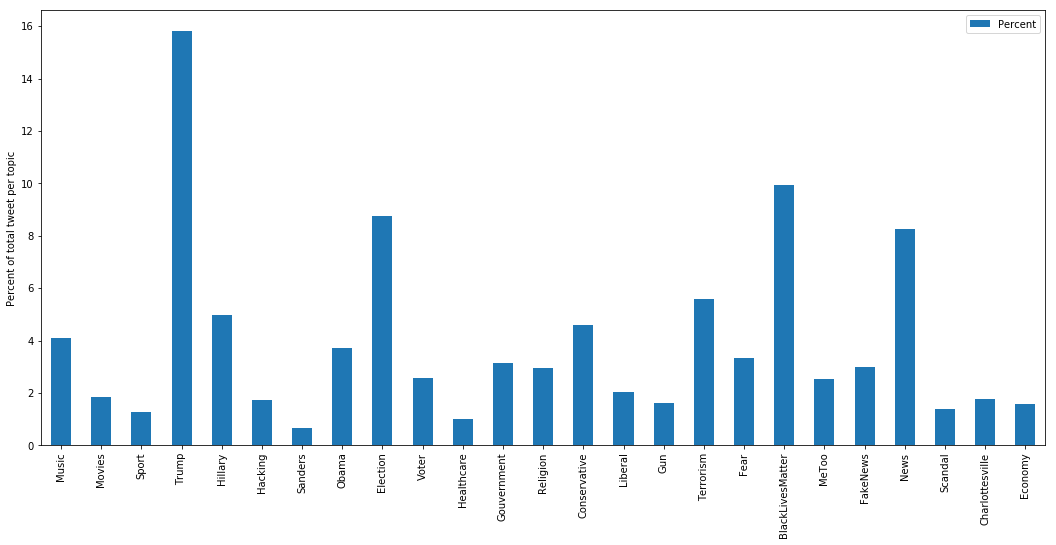

In [63]:
#plotting
ax=topic_proportion[['Percent']].plot.bar(stacked=True, figsize=(18,8))
ax.set(ylabel='Percent of total tweet per topic')
plt.show()

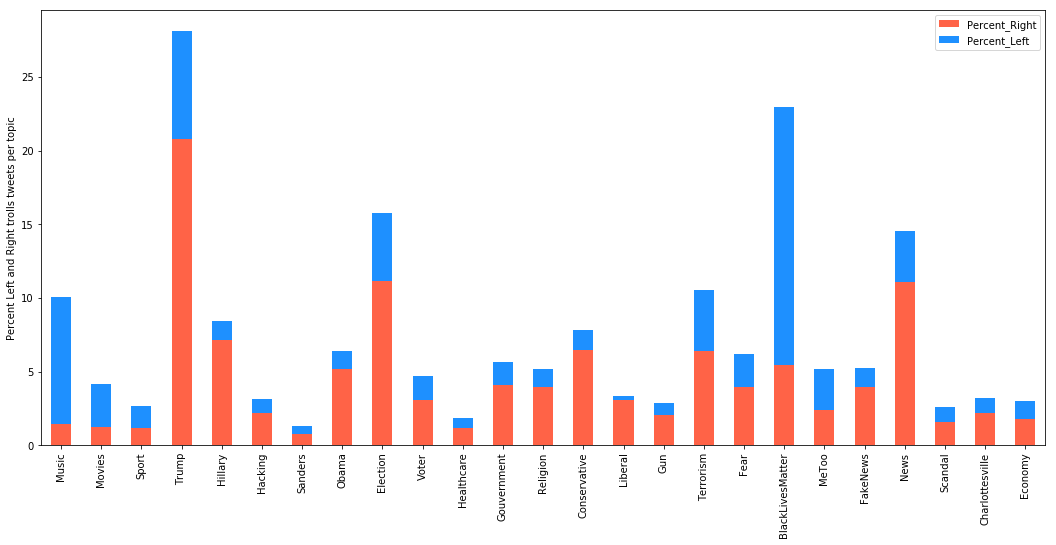

In [64]:
ax=topic_proportion[['Percent_Right','Percent_Left']].plot.bar(stacked=True, \
                                                               figsize=(18,8), color=['tomato', 'dodgerblue'])
ax.set(ylabel='Percent Left and Right trolls tweets per topic')
plt.show()

In [42]:
uncat_vocabulary=get_uncat_voc(df[df.Categorical == 0].Clean_tweet, min_count=30)

Vocab loaded <---


In [43]:
#uncategorized words
uncat_vocabulary.sort_values(by='Count', ascending=False).head(10)

,Word,Count
180,peopl,15886.0
269,break,12559.0
302,video,9396.0
153,right,9312.0
498,white,8515.0
484,think,8176.0
350,thank,7988.0
258,american,7460.0
36,thing,7142.0
231,never,6991.0


In [65]:
#how the list is extended: finds similar words
word='data'
try:
    print('\n'.join([str(w) for w in model.wv.most_similar(stemmer.stem(word), topn=15)]))
except KeyError:
    print('Not in vocabulary or excluded during pre-processing.')

('softwar', 0.6067728400230408)
('comput', 0.6056808829307556)
('research', 0.5867613554000854)
('document', 0.5866277813911438)
('analyt', 0.5711698532104492)
('server', 0.5566795468330383)
('info', 0.5438840985298157)
('cybersecur', 0.5357222557067871)
('hacker', 0.5305755734443665)
('carbon', 0.5293706059455872)
('email', 0.5254548192024231)
('noaa', 0.524185061454773)
('databas', 0.5202736854553223)
('loophol', 0.5190874338150024)
('inform', 0.5187277793884277)


**The extended list is here.** Note that the words are stemmed. For instance, the sufixes *'ing', 's', 'e'* are removed.

In [66]:
print('#-Topic-# : {} '.format('\n-----\n#-Topic-# : '.join([str(topic) for topic in topic_extended])))

#-Topic-# : ['Music', 'music', 'hip-hop', 'song', 'music', 'solang', 'lyric', 'eyez', 'ep', 'donaldglov', 'okayplay', 'platinum', 'album', 'songwrit', 'unsign', 'self-taught', 'musician', 'dagr8fm', 'djshinnergmailcom', 'intro', 'djshinner', 'nowplay', 'datpiff', 'click', 'audiomack', 'widget', 'recordd', 'soundcloud', 'hiphop', 'rap', 'hiphopgod', 'webreaktrax', 'djquestgh', 'mixshow', 'rappersiq', 'dancehal', 'hiphopartist', 'topstarhiphopra', 'musicmoney', 'spitter', 'makebeat', 'ricorecklezz', 'nervedjsmixtap', 'hhchiphop', 'disc', 'winnin', 'powertalkwog', 'outro', 'quavostuntin', 'hip-hop', 'soca', 'breeziefbabi', 'regga', 'kingbon', 'tidalhifi', 'futureofnewyork', 'pandora', 'groov', 'gorillaz', 'daveeast', 'rnb', 'rnb', 'music', 'tidalhifi', 'duo', 'variant', 'hip-hop', 'eminem', 'mikewillmadeit', 'daveeast', 'asvpxrocki', 'youngthug', 'sade', 'donaldglov', 'therealkiss', 'jermainedupri', 'beatz', 'liluzivert', 'trvisxx', 'djkhale', 'raekwon', 'dmx', 'liltunechi', 'wizkhalifa',